# Hierarchical Attention Networks for Document Classification
PyTorch implementation of **Hierarchical Attention Networks for Document Classification (NAACL 2016)**

# Table of Contents
* [Preamble](#Preamble)
* [Word2Vec Module](#Word2Vec-Module)
* [Load Vocabulary and Embeddings](#Load-Vocabulary-and-Embeddings)
    * [Negative sampling](#Negative-sampling)
    * [GloVe](#GloVe)
* [PyTorch Dataset class](#PyTorch-Dataset-class)
* [HAN Model](#HAN-Model)
* [Training](#Training)

# Preamble

In [1]:
# Preamble
import time, random
import re, string
import os, sys
import math
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

# Word2Vec Module
Following the original paper, we trained the word embeddings using *Negative sampling* technique introduced in **Distributed Representations of Words and Phrases and their Compositionality (NIPS 2013)**

In [2]:
# Negative sampling embedding module
class NegSamplingEmbedding(nn.Module):
    '''
    Vocab_size: V
    Embedding_size: E
    Text_length: L
    Batch_size: B
    
    Consult: https://github.com/mindspore-courses/DeepNLP-models-MindSpore/
            blob/main/notebooks/02.Skip-gram-Negative-Sampling.ipynb
    '''
    def __init__(self, vocab_size, embedding_size):
        super(NegSamplingEmbedding, self).__init__()
        self.U = nn.Embedding(vocab_size, embedding_size) # Center embedding
        self.V = nn.Embedding(vocab_size, embedding_size) # Outside embedding
        self.LogSig = nn.LogSigmoid()
        
    def forward(self, wc, wo, wk, mask_c, mask_o, check_shape= False):
        vc = self.V(wc) # Center embedding. Shape: (B, L, E)
        uo = self.U(wo) # Outside embedding. Shape: (B, L, C, E)
        uk = self.U(wk) # Random embedding. Shape: (B, L, C, E, K)
        
        if check_shape:
            B = uk.shape[0]
            L = uk.shape[1]
            C = uk.shape[2]
            K = uk.shape[3]
            E = uk.shape[4]
            print(f"Basic shapes: B = {B}; L = {L}; C = {C}; K = {K}; E = {E}")
            print('*********************************')
            print('Shape of vc:', vc.shape)
            print('Shape of uo:', uo.shape)
            print('Shape of uk:', uk.shape)
            print('*********************************')
        cmp1 = torch.einsum('blce,ble->blc', uo, vc) # Shape: (B, L, C)
        cmp2 = torch.einsum('blcke,ble->blck', uk, vc) # Shape: (B, L, C, K)
        
        cmp1 = self.LogSig(cmp1) * mask_o # Shape: (B, L, C)
        cmp2 = self.LogSig(-cmp2) # Shape: (B, L, C, K)
        cmp2 = torch.einsum('blck->blc', cmp2) * mask_o # Shape: (B, L, C)
    
        cmp1 = torch.einsum('blc->bl', cmp1) # Shape: (B, L)
        cmp2 = torch.einsum('blc->bl', cmp2) # Shape: (B, L)
        
        loss = torch.mean(cmp1 + cmp2)
        
        if check_shape:
            print('Shape of cmp1:', cmp1.shape)
            print('Shape of cmp2:', cmp2.shape)
            print('Shape of LOSS:', loss.shape)
        return -loss

# Load Vocabulary and Embeddings

In [3]:
# Embedding type. 'glove' or 'negative_sampling'
MODE = 'glove'

## Negative sampling
Here we load the pretrained vocab and embeddings constructed using **Negative Sampling.**

In [4]:
# Prepare vocab, counter, tokenizer
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab, build_vocab_from_iterator

from collections import Counter

tokenizer = get_tokenizer("basic_english")

vocab_ns = torch.load('/kaggle/input/hlt-word2vec/vocab.pth')

In [5]:
# Task configs
VOCAB_SIZE = len(vocab_ns)
EMBEDDING_DIM = 200
GRU_DIM = 50
NUM_CLASSES = 5

In [6]:
# Prepare word embeddings
WORD2VEC_PATH = '/kaggle/input/hlt-word2vec/word2vec.pth'
word2vec = NegSamplingEmbedding(VOCAB_SIZE, EMBEDDING_DIM)
word2vec.load_state_dict(torch.load(WORD2VEC_PATH, map_location= DEVICE))
word2vec.eval()

W_e = word2vec.V.weight.detach().to(DEVICE)

## GloVe
Here we import pretrained word embeddings **GloVe**. We plan on evaluating HAN using GloVe 6B $(D = 200)$ and GloVe 42B $(D = 300)$.

In [7]:
# Double check vocab - embedding matching
def arr_equal_check(arr1, arr2):
    if len(arr1) != len(arr2):
        return False
    
    for i in range(len(arr1)):
        if arr1[i] != arr2[i]:
            return False
        
    return True

In [8]:
# Load GloVe embeddings
EMBEDDING_DIM = 300

glove_txt = '/kaggle/input/glovewordembeddings/glove.42B.300d.txt'
with open(glove_txt, 'r') as file:
    lines = file.readlines()
    file.close()

W_list = []
word_list = ['<unk>']
freq = {} # Construct vocab from dict 

for line in lines:
    words = line.split(' ')
    word = words[0]
    word_list.append(word)
    freq[word] = 1
    
    arr = np.array(words[1:], dtype= float)
    W_list.append(torch.tensor(arr, dtype= torch.float))
    
unk_embed = [sum(W_list) / len(W_list)]
W_list = unk_embed + W_list

W_glove = torch.stack(W_list).to(DEVICE)
vocab_glove = vocab(
    freq,
    specials= ["<unk>"]
)
vocab_glove.set_default_index(vocab_glove["<unk>"])

# Make sure vocab match word embeddings
assert arr_equal_check(vocab_glove.get_itos(), word_list)

# PyTorch Dataset class

In [9]:
# YELP Dataset
def collate_batch(batch):
    '''
    Collate batch with zero-padding
    Consult: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
    '''
    texts = []
    labels = []
    mask = []
    for _text, _label in batch:
        texts.append(_text)
        labels.append(_label)
        
    L = max([len(text) for text in texts])
    
    for i in range(len(texts)):
        l = texts[i].shape[0]
        cur_mask = torch.ones(L)
        if l < L:
            cur_mask[l:L] = 0
            # Zero-padding text, only on one side.
            texts[i] = F.pad(texts[i], (0, L-l), 'constant', 0)
            
        mask.append(cur_mask)
    
    texts = torch.stack(texts)
    labels = torch.stack(labels)
    mask = torch.stack(mask)
    return texts, labels, mask

def collate_batch_HAN(batch):
    return batch

class YELPDataset(Dataset):
    def __init__(self, df, vocab, tokenizer, df_sort= True, punct_splt= False):
        self.df = df
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.len_vocab = len(vocab)
        self.punct_splt = punct_splt
        if df_sort:
            self.sort_df_by_txt_len()
    
    def sort_df_by_txt_len(self):
        len_list = [-len(re.split("[.!?]+", self.df.iloc[i]['text'])) for i in range(len(self.df))]
        self.df = self.df.iloc[np.argsort(len_list)]
    
    def __len__(self):
        return len(self.df)

    def text_pipeline(self, x):
        x = x.replace('\'', '')
        return self.vocab(self.tokenizer(x))

    def label_pipeline(self, x):
        return int(x) - 1
    
    def __getitem__(self, idx):
        if not self.punct_splt:
            txt = self.text_pipeline(self.df.iloc[idx]['text'])
            txt = torch.tensor(txt, dtype= torch.int64)

            label = self.label_pipeline(self.df.iloc[idx]['stars'])
            label = torch.tensor(label, dtype= torch.int64)

            return (txt, label)
    
        else:
            txt = self.df.iloc[idx]['text']
            sentences = re.split("[.!?]+", txt)
            L = 0
            X = []
            mask = []
            
            for s in sentences:
                l = len(s)
                if l == 0:
                    continue
                X.append(torch.tensor(self.text_pipeline(s), dtype= torch.int64))
                L = max(L, X[-1].shape[0])
                
            if len(X) == 0:
                return (None, None, None)
            
            for i in range(len(X)):
                l = X[i].shape[0]
                cur_mask = torch.ones(L)
                
                # Zero-padding sentence
                if(l < L):
                    # Zero-padding sentence, only on one side.
                    X[i] = F.pad(X[i], (0, L - l), 'constant', 0)
                    cur_mask[l:L] = 0
                
                mask.append(cur_mask)
                    
            X = torch.stack(X)
            mask = torch.stack(mask)
            
            label = self.label_pipeline(self.df.iloc[idx]['stars'])
            label = torch.tensor(label, dtype= torch.int64)
            
            return (X, label, mask)

In [10]:
# CSV Preparation
data_file = open("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json")
data = []

cnt = 1569264 # Size of YELP 2015 dataset
# cnt = 10000

for line in data_file:
    data.append(json.loads(line))
    cnt -= 1
    if cnt == 0:
        break
    
data_file.close()
df = pd.DataFrame(data)

print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 1569264


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [11]:
# Train-val-test splits
df_size = len(df)
idx = [x for x in range(df_size)]
random.Random(555).shuffle(idx)

train_num = int(df_size * 0.8)
val_num = int(df_size * 0.01)
test_num = int(df_size * 0.1)

# print(train_num, val_num, test_num)

train_idx = idx[:train_num]
val_idx = idx[train_num : (train_num + val_num)]
test_idx = idx[(train_num + val_num) : ]

train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

print('Size of trainset:', len(train_df))
print('Size of valset:', len(val_df))
print('Size of testset:', len(test_df))

Size of trainset: 1255411
Size of valset: 15692
Size of testset: 298161


In [12]:
# Dataset, Dataloader
if MODE == 'glove':
    data_vocab = vocab_glove
if MODE == 'negative_sampling':
    data_vocab = vocab_ns

trainset = YELPDataset(train_df, data_vocab, tokenizer, punct_splt= True)
valset = YELPDataset(val_df, data_vocab, tokenizer, punct_splt= True)
testset = YELPDataset(test_df, data_vocab, tokenizer, punct_splt= True)

trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, 
                         shuffle= False, pin_memory= True, collate_fn= collate_batch_HAN)
valloader = DataLoader(valset, batch_size= BATCH_SIZE, 
                         shuffle= False, pin_memory= True, collate_fn= collate_batch_HAN)
testloader = DataLoader(testset, batch_size= BATCH_SIZE, 
                         shuffle= False, pin_memory= True, collate_fn= collate_batch_HAN)

for batch in trainloader:
    X, y, mask = batch[0]
    print("Shape of Texts:", X.shape)
    print("Shape of Labels:", y.shape)
    print("Shape of Mask:", mask.shape)
    break

Shape of Texts: torch.Size([154, 27])
Shape of Labels: torch.Size([])
Shape of Mask: torch.Size([154, 27])


# HAN Model

In [13]:
class HANModel(nn.Module):
    def __init__(self, W_e, embedding_dim, gru_dim, 
                 num_classes):
        super(HANModel, self).__init__()
        
        DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        # Initialize
        self.E = embedding_dim
        self.G = gru_dim
        self.num_classes = num_classes
        
        # Pretrained word embeddings
        self.W_e = W_e
        
        # Word-level attention
        self.WordEncoder = nn.GRU(
            input_size= embedding_dim,
            hidden_size= gru_dim,
            batch_first= True,
            bidirectional= True
        )
        self.WordMLP = nn.Sequential(
            nn.Linear(2*gru_dim, 2*gru_dim),
            nn.Tanh()
        )
        self.u_w = nn.Parameter(torch.randn(2*gru_dim))
        
        # Sequence-level attention
        self.SeqEncoder = nn.GRU(
            input_size= 2*gru_dim,
            hidden_size= gru_dim,
            batch_first= True,
            bidirectional= True
        )
        self.SeqMLP = nn.Sequential(
            nn.Linear(2*gru_dim, 2*gru_dim),
            nn.Tanh()
        )
        self.u_s = nn.Parameter(torch.randn(2*gru_dim))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(2*gru_dim, num_classes),
            nn.Softmax()
        )
        
    def forward(self, text, mask, check_shape= False):
        '''
        <text> is expected to have shape (S, L)
        
        Number of sentence: S
        Max sentence length: L
        Embedding size: E
        GRU dimension: G -> Bidirectional: 2G
        '''
        S = text.shape[0]
        L = text.shape[1]
        
        x = self.W_e[text] # Text embedding, Shape: (S, L, E)
        hW,_ = self.WordEncoder(x) # Word annotation. Shape: (S, L, 2G)
        uW = self.WordMLP(hW) # Word hidden representation. Shape: (S, L, 2G)

        # Attention weight - Needs verifications
        alphaW = nn.Softmax()(torch.einsum('slg,g->sl', uW, self.u_w) * mask) # Shape: (S, L)
        
        # Sentence vector
        s = torch.einsum('slg,sl->sg', hW, alphaW) # Shape: (S, 2G)
        hS,_ = self.SeqEncoder(s) # Sentence annotation. Shape: (S, 2G)
        uS = self.SeqMLP(hS) # Sentence hidden representation. Shape: (S, 2G)
        
        # Attention weight - Needs verifications
        alphaS = nn.Softmax()(torch.matmul(uS, self.u_s)) # Shape: (S)
        
        # Document vector
        v = torch.matmul(alphaS, hS)
        
        logits = self.classifier(v)
        
        if check_shape:
            print(f'Basic shapes: S = {S}, E = {self.E}, L = {L}, G = {self.G}')
            print('*********************************')
            print('Shape of x:', x.shape)
            print('Shape of hW:', hW.shape)
            print('Shape of uW:', uW.shape)
            print('Shape of alphaW:', alphaW.shape)
            print('*********************************')
            print('Shape of s:', s.shape)
            print('Shape of hS:', hS.shape)
            print('Shape of uS:', uS.shape)
            print('Shape of alphaS:', alphaS.shape)
            print('*********************************')
            print('Shape of v:', v.shape)
            print('Shape of logits:', logits.shape)
        
        return logits
        

In [14]:
# Xavier normal initialization
def xavier_normal_init(m):
    '''
    Xavier normal initialization.
    '''
    if type(m) == nn.Linear or type(m) == nn.Parameter:
        print(m)
        torch.nn.init.xavier_normal_(m.weight)

In [15]:
model = HANModel(W_glove, EMBEDDING_DIM, GRU_DIM, NUM_CLASSES).to(DEVICE)
print('*********************************')
print('Submodules having Xavier normal initialization:')
model.apply(xavier_normal_init)
print('*********************************')

for batch in trainloader:
    X, y, mask = batch[0]
    X, mask = X.to(DEVICE), mask.to(DEVICE)
    logits = model(X, mask, check_shape= True)
    break
    
print('*********************************')
print(model)

*********************************
Submodules having Xavier normal initialization:
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=100, bias=True)
Linear(in_features=100, out_features=5, bias=True)
*********************************
Basic shapes: S = 154, E = 300, L = 27, G = 50
*********************************
Shape of x: torch.Size([154, 27, 300])
Shape of hW: torch.Size([154, 27, 100])
Shape of uW: torch.Size([154, 27, 100])
Shape of alphaW: torch.Size([154, 27])
*********************************
Shape of s: torch.Size([154, 100])
Shape of hS: torch.Size([154, 100])
Shape of uS: torch.Size([154, 100])
Shape of alphaS: torch.Size([154])
*********************************
Shape of v: torch.Size([100])
Shape of logits: torch.Size([5])
*********************************
HANModel(
  (WordEncoder): GRU(300, 50, batch_first=True, bidirectional=True)
  (WordMLP): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


# Training

In [16]:
# Training configs
LR = 1e-3
MOMENTUM = 0.9
EPOCHS = 3
ITER = EPOCHS * len(trainloader)
OPTIMIZER = torch.optim.AdamW(model.parameters(), lr= LR)
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr= LR, momentum= MOMENTUM, nesterov= True)
SCHEDULER = lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(OPTIMIZER, T_max = ITER)
LOSS_FN = nn.CrossEntropyLoss()
RECORD = 0.0

In [17]:
# Train procedures
def test(testloader, model, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    bcnt = 0
    cnt = 0
    
    for i, batch in enumerate(testloader):
        tmp_loss = 0
        cnt += 1
        for (X, y, mask) in batch:
            if X is None:
                continue
            bcnt += 1
            X, y, mask = X.to(DEVICE), y.to(DEVICE), mask.to(DEVICE)
            pred = model(X, mask)
            tmp_loss += loss_fn(logits, y).item()
            correct += (pred.argmax(0) == y).type(torch.float).sum().item()
        tmp_loss /= len(batch)
        test_loss += tmp_loss
        
    test_loss /= len(testloader)
    accuracy = correct / len(testloader.dataset)
    
    return test_loss, accuracy

def train(trainloader, valloader, model, optimizer, scheduler, loss_fn, val_freq):
    global RECORD
    model.train()
    tloss = []
    cur_acc = 0
    for i, batch in enumerate(trainloader):
        loss = 0
        for (X, y, mask) in batch:
            if X is None:
                continue
            X, y, mask = X.to(DEVICE), y.to(DEVICE), mask.to(DEVICE)
            logits = model(X, mask)
            loss += loss_fn(logits, y)
        loss /= len(batch)
        
        if val_freq > 0 and i % val_freq == 0:
            tloss.append(loss.cpu().detach().numpy())
            model.eval()
            val_loss, val_acc = test(valloader, model, loss_fn)
            model.train()
            print(f'Iter {i}, loss = {tloss[-1]}, val_acc = {val_acc}')
            if RECORD < val_acc:
                RECORD = val_acc
                print('Saving model...')
                torch.save(model.state_dict(), f'HAN_{val_acc*100}.pth')
                torch.save(model.state_dict(), f'HAN_best.pth')
        
        tloss.append(loss.cpu().detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    model.eval()
    val_loss, val_acc = test(valloader, model, loss_fn)
    model.train()
    print(f'Iter {i}, loss = {tloss[-1]}, val_acc = {val_acc}')
    if RECORD < val_acc:
        RECORD = val_acc
        print('Saving model...')
        torch.save(model.state_dict(), f'HAN_{val_acc*100}.pth')
        torch.save(model.state_dict(), f'HAN_best.pth')
        
    return tloss

Epoch 0 starts.


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Iter 0, loss = 1.610776662826538, val_acc = 0.19404792250828448
Saving model...
Iter 1000, loss = 1.336042881011963, val_acc = 0.6147718582717309
Saving model...
Iter 2000, loss = 1.3050657510757446, val_acc = 0.6075070099413714
Iter 3000, loss = 1.2617769241333008, val_acc = 0.6642238083099669
Saving model...
Iter 4000, loss = 1.2269591093063354, val_acc = 0.6783711445322458
Saving model...
Iter 5000, loss = 1.2264152765274048, val_acc = 0.6840428243691052
Saving model...
Iter 6000, loss = 1.200705647468567, val_acc = 0.6839790976293653
Iter 7000, loss = 1.157285451889038, val_acc = 0.699273515166964
Saving model...
Iter 8000, loss = 1.1436022520065308, val_acc = 0.7036069334692837
Saving model...
Iter 9000, loss = 1.1320769786834717, val_acc = 0.7043079276064237
Saving model...
Iter 10000, loss = 1.1760168075561523, val_acc = 0.7009304104002039
Iter 11000, loss = 1.1939465999603271, val_acc = 0.7054550089217435
Saving model...
Iter 12000, loss = 1.1599706411361694, val_acc = 0.703415

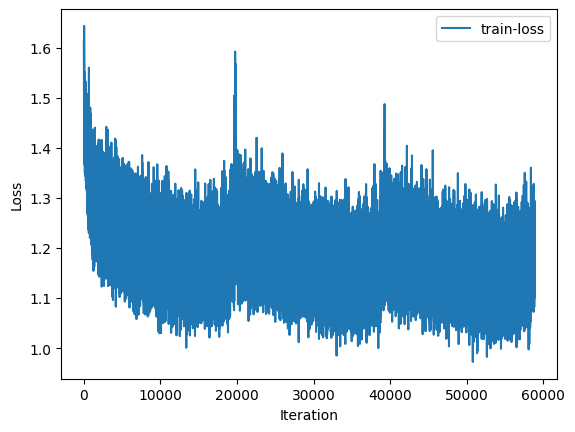

In [18]:
# TRAINING
iter_loss = []
epoch_loss = []
best_acc = 0

for t in range(EPOCHS):
    print(f'Epoch {t} starts.')
    tloss = train(trainloader, valloader, model, OPTIMIZER, SCHEDULER, LOSS_FN, 1000)
    val_loss, val_acc = test(valloader, model, LOSS_FN)
    
    iter_loss = iter_loss + tloss
    epoch_loss.append(sum(tloss) / len(tloss))
    
    print(f'Epoch {t}: LOSS = {epoch_loss[-1]}, VAL-ACC = {val_acc}')
    
torch.save(model.state_dict(), f'HAN_last.pth')
    
fig, axes = plt.subplots()
axes.plot(iter_loss, label = 'train-loss')
axes.legend()
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.show()

In [19]:
_, val_acc = test(testloader, model, LOSS_FN)
print(f'(LAST) Test accuracy: {val_acc}')

(LAST) Test accuracy: 0.7255543146152582


In [20]:
model.load_state_dict(torch.load('HAN_best.pth', map_location= DEVICE))
_, val_acc = test(testloader, model, LOSS_FN)
print(f'(BEST) Test accuracy: {val_acc}')

(BEST) Test accuracy: 0.7277645299016303
